In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(0)

In [3]:
# Import data
train = datasets.get_mnist('balanced')
test = datasets.get_mnist('balanced', train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 32
nu = 0.0001
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'pie_dense_unsup_fr_pca'

In [4]:
# Initialize dimensions, models, parameters and optimizers
dims = [M] * 3

model_kwargs = {
    'activation': modules.InvertibleID,
    'activation_params': {},
    'device': device
}

nets = {
    "PIE": models.dense.AdjointDense(dims, **model_kwargs),
    "AE": models.dense.AEDense(dims, **model_kwargs),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)

In [5]:
# Define objective function

def objective_function(x, xh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = F.mse_loss(xh, x, reduction=reduction)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [6]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:5}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params PIE  :  1230880
No. params AE   :  2461760


In [7]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.tensor(train.data[sample_indices_small]).float() / 255
xs = xims.flatten(-2, -1).to(device)
xt = torch.tensor(test.data).float().flatten(-2, -1).to(device) / 255

In [8]:
# Masking

def cooldown(e, i, p=1.8, tot=epochs*len(loader)):
    cur = e * len(loader) + i
    c = int(round( M * (cur / tot)**p ))
    if c > M-1:
        c = M-1
    return c

def get_mask(e, i, dims=(M, M), row=True, **kwargs):
    c = cooldown(e, i, **kwargs)
    mask = torch.zeros(dims).to(device)
    if row:
        mask[c] = 1
    else:
        mask[:, c] = 1
    return mask

In [9]:
mu_x = torch.mean(torch.tensor(train.data).float().flatten(-2, -1) / 255., dim=0)

def normalize(x):
    return x - mu_x.to(x.device)

def unnormalize(x):
    return x + mu_x.to(x.device)

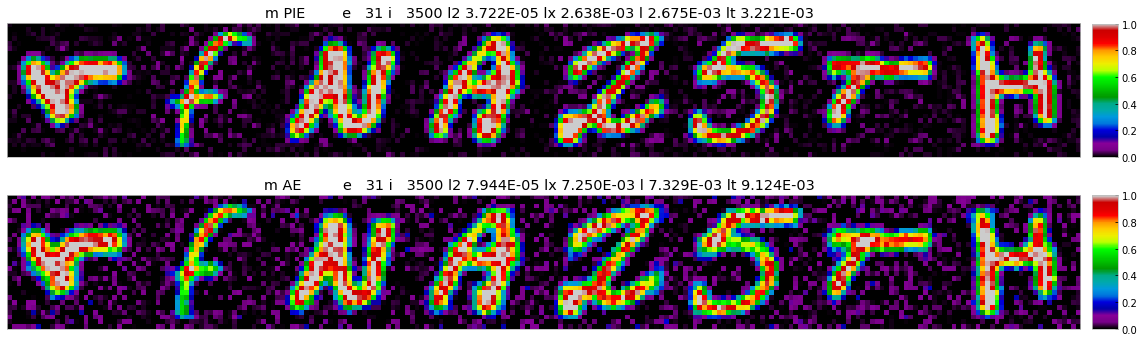

In [10]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        x = normalize(x)
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            y = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, nets[cur].parameters())

            loss.backward()
            rmask = get_mask(e, i, row=True)
            cmask = get_mask(e, i, row=False)
            
            if cur == 'PIE':
                nets[cur].net.V.weight.grad = nets[cur].net.V.weight.grad * rmask
                nets[cur].net.U.weight.grad = nets[cur].net.U.weight.grad * cmask
            
            else:
                nets[cur].net_fwd.V.weight.grad = nets[cur].net_fwd.V.weight.grad * rmask
                nets[cur].net_fwd.U.weight.grad = nets[cur].net_fwd.U.weight.grad * cmask
                nets[cur].net_bck.U.weight.grad = nets[cur].net_bck.U.weight.grad * rmask
                nets[cur].net_bck.V.weight.grad = nets[cur].net_bck.V.weight.grad * cmask
                        
            opts[cur].step()
            
            # Validation
            with torch.no_grad():
                yt = nets[cur](xt)
                xth = nets[cur].T(yt)
                ldicts[cur]['lt'] = F.mse_loss(xth, xt, reduction='mean')

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    ys = nets[cur](xs)
                    xhs[cur] = nets[cur].T(ys)
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name)
            
        i += 1

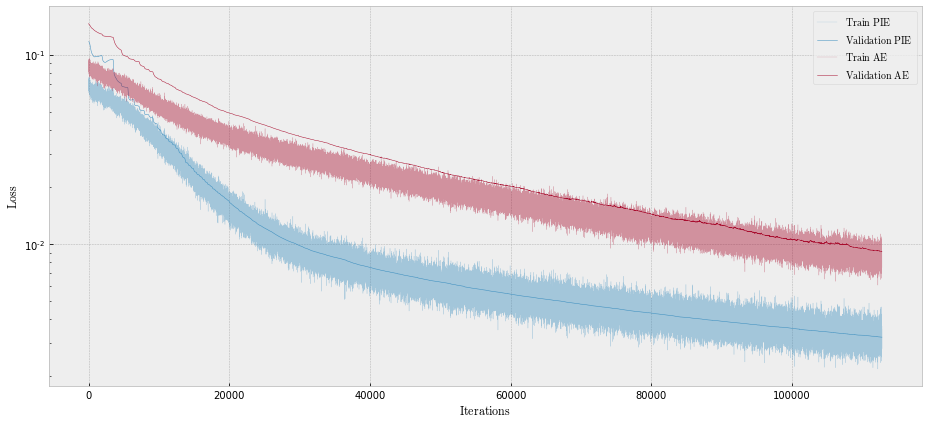

In [11]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    p = plt.plot(np_loss_trace[k]["l"], linewidth=.3, label=f"$\mathrm{{Train\,\,{k}}}$", alpha=0.4)
    plt.plot(np_loss_trace[k]["lt"], linewidth=.5, label=f"$\mathrm{{Validation\,\,{k}}}$", alpha=0.95, color=p[0].get_color())

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

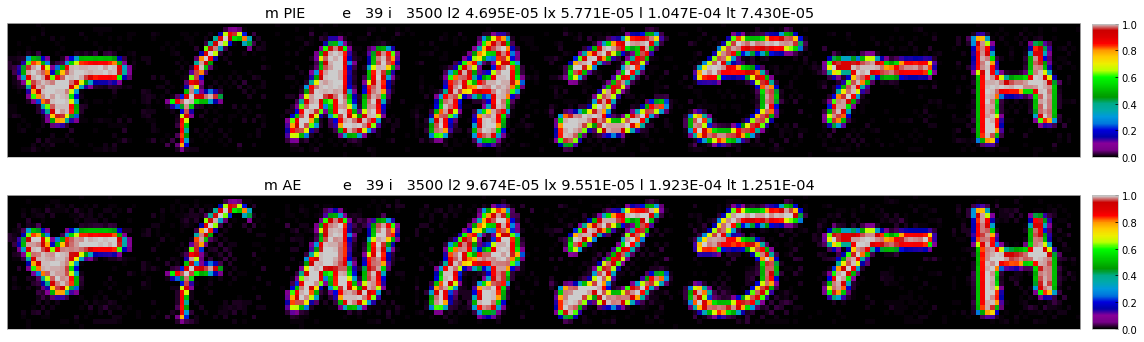

In [12]:
# Training loop: Full

full_epochs = 8

for e in range(epochs, epochs + full_epochs):
    i = 0
    for x, y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        x = normalize(x)
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            y = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, nets[cur].parameters())
            
            loss.backward()                        
            opts[cur].step()

            # Validation
            with torch.no_grad():
                yt = nets[cur](xt)
                xth = nets[cur].T(yt)
                ldicts[cur]['lt'] = F.mse_loss(xth, xt, reduction='mean')
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    ys = nets[cur](xs)
                    xhs[cur] = nets[cur].T(ys)
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name)
            
        i += 1

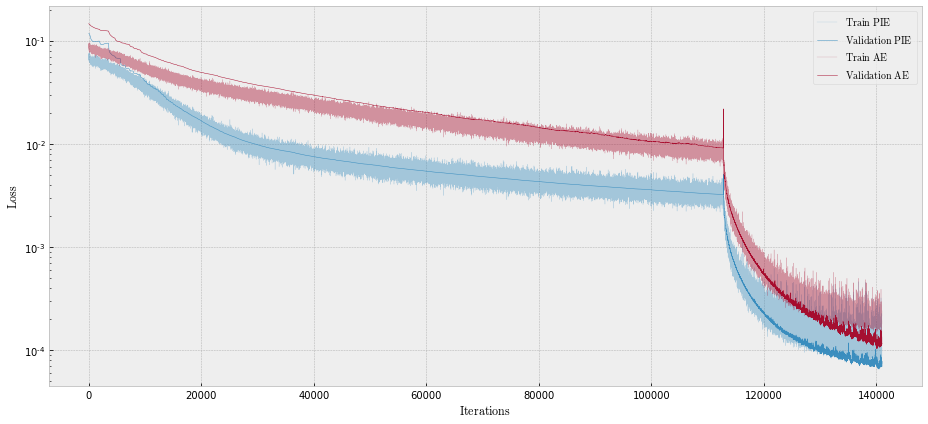

In [13]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    p = plt.plot(np_loss_trace[k]["l"], linewidth=.3, label=f"$\mathrm{{Train\,\,{k}}}$", alpha=0.4)
    plt.plot(np_loss_trace[k]["lt"], linewidth=.5, label=f"$\mathrm{{Validation\,\,{k}}}$", alpha=0.95, color=p[0].get_color())

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}_2.pdf')

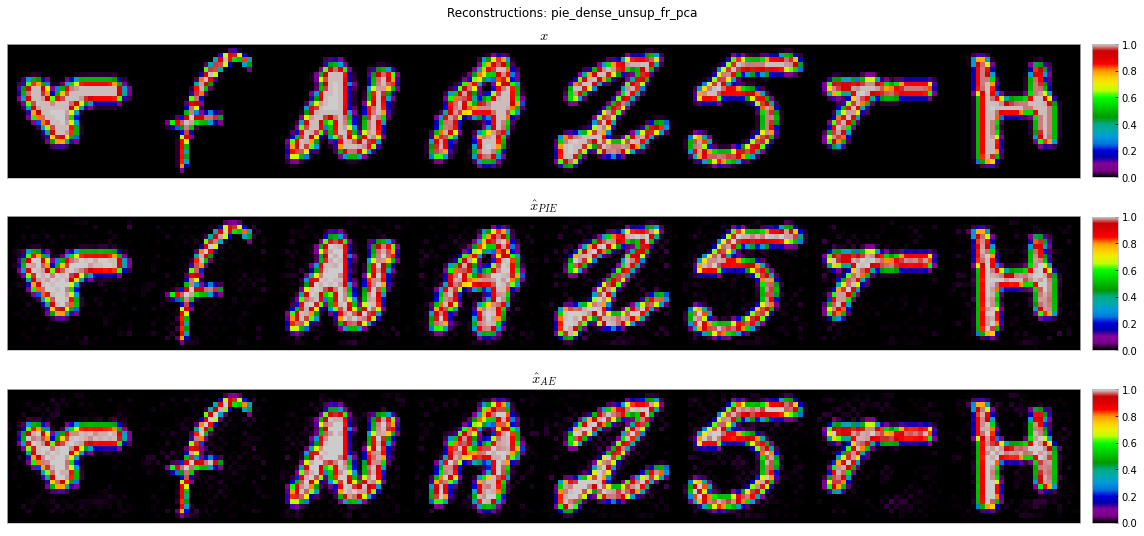

In [14]:
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = nets[k].T(nets[k](xs))
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
    
utils.reporting.plot_results(xhs, f'Reconstructions: {experiment_name}', fname=experiment_name)

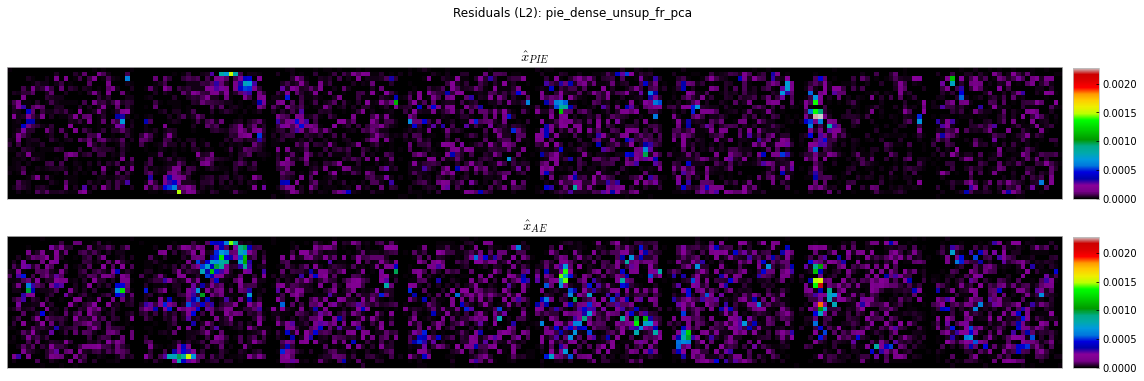

In [15]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = nets[k].T(nets[k](xs))
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [16]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [17]:
# Calculate relative error on test data
test_tensor = torch.tensor(test.data.astype(float) / 255).flatten(-2, -1).float()
print(f"Relative Error:")

for k, model in nets.items():
    XH = model.T(model(test_tensor))
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(test_tensor, XH, reduction='mean'):4E} " +
        f"MSE {F.mse_loss(test_tensor, XH, reduction='mean'):4E} "
    )

# Clear memory
del XH

Relative Error:
PIE   : RE 2.127095E-02 MSE 7.462336E-05 
AE    : RE 2.757853E-02 MSE 1.170283E-04 


In [39]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    XH = model.T(model(test_tensor))
    psnr = utils.metrics.psnr(test_tensor, XH)
    ssim = utils.metrics.ssim(
        test_tensor.unflatten(-1, (28, 28))[None,...], 
        XH.unflatten(-1, (28, 28))[None,...]
    )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

# Clear memory
del XH

Image Reconstruction Metrics:
PIE   : PSNR 4.127125E+01 SSIM 9.866969E-01 
AE    : PSNR 3.931709E+01 SSIM 9.746497E-01 


In [18]:
# Compute Estimated Generalized Inverses
Ids = {}
for k, model in nets.items():
    with torch.no_grad():
        dct = model.get_weight_dict()
        Ids[k] = dct['V.T'] @ dct['U.T'] @ dct['U'] @ dct['V']

# Note: Moore-Penrose Pseudoinverse is calculated using test data
#       which has fewer (18800) observations than training (112800)
Ids['PIn'] = torch.pinverse(test_tensor) @ test_tensor

In [19]:
# Relative error to Identity
print("Relative Error w.r.t. Identity (Frobenius Norm):")
for k, I in Ids.items():
    print(f"{k:3}: {utils.metrics.relative_error_matrix(torch.eye(M), I, 'fro')}")

Relative Error w.r.t. Identity (Frobenius Norm):
PIE: 0.5789178013801575
AE : 0.5974239706993103
PIn: 0.5413821935653687


In [20]:
print("Relative Error w.r.t. symmetry of Moore-Penrose properties (Frobenius Norm):")
for k, I in Ids.items():
    print(f"{k:3}: {utils.metrics.relative_error_matrix(test_tensor, test_tensor @ I, 'fro'):.6f}")

Relative Error w.r.t. symmetry of Moore-Penrose properties (Frobenius Norm):
PIE: 0.022923
AE : 0.134141
PIn: 0.000071


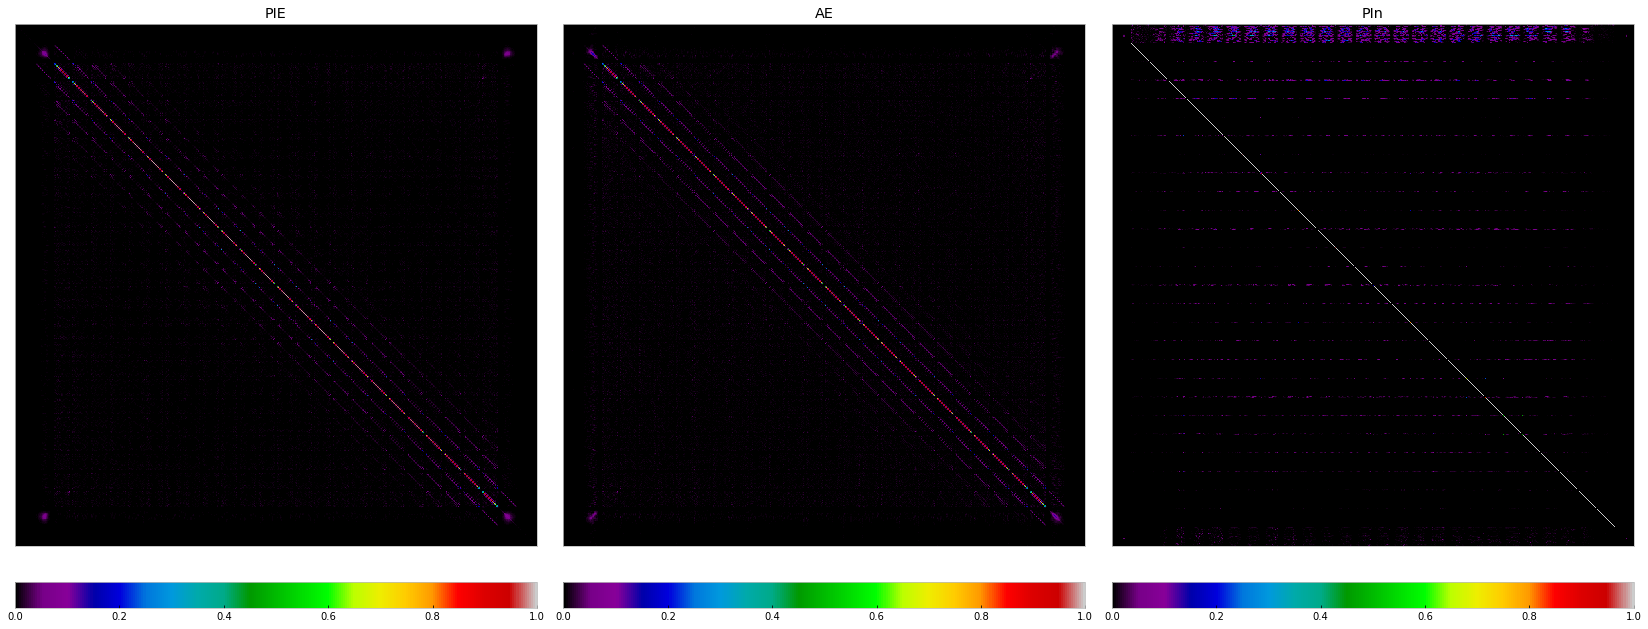

In [21]:
# Plot approximate identity operators
fig, axs = plt.subplots(1, 3, figsize=(23,13))
for i, (k, I) in enumerate(Ids.items()):
    im = axs[i].matshow(I, cmap='nipy_spectral', vmin=0, vmax=1)
    axs[i].grid(False)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(f"{k}")
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04, orientation="horizontal")
    
plt.savefig(f'../figures/other/{experiment_name}_identities.pdf')

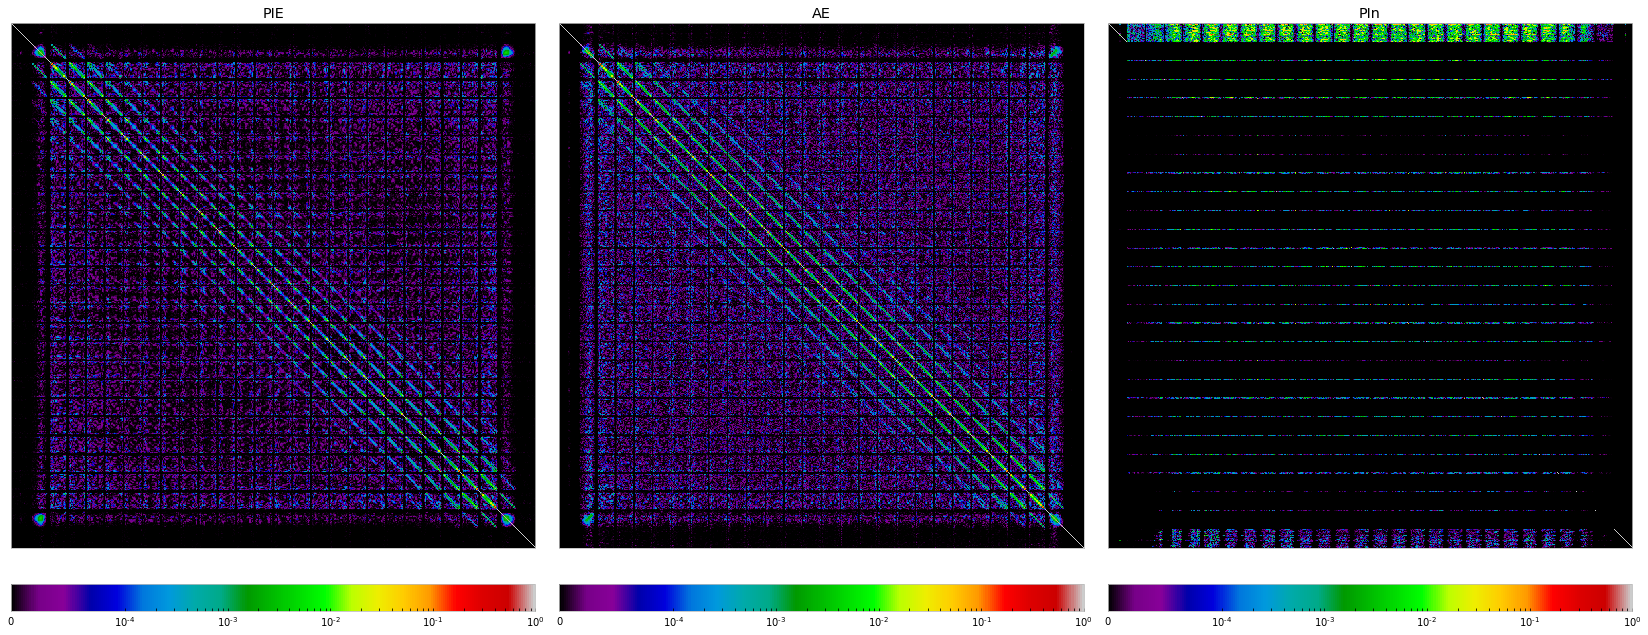

In [22]:
# Plot residuals (L2) of approximate identity operators

from matplotlib.colors import LogNorm, SymLogNorm

fig, axs = plt.subplots(1, 3, figsize=(23,13))
for i, (k, I) in enumerate(Ids.items()):
    # Fix bug in LogNorm color
    res_I = (I - torch.eye(M))**2
    im = axs[i].matshow(res_I, cmap='nipy_spectral', norm=SymLogNorm(1e-4, vmax=1, base=10))
    axs[i].grid(False)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(f"{k}")
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04, orientation="horizontal")
    
plt.savefig(f'../figures/other/{experiment_name}_identities_residuals.pdf')

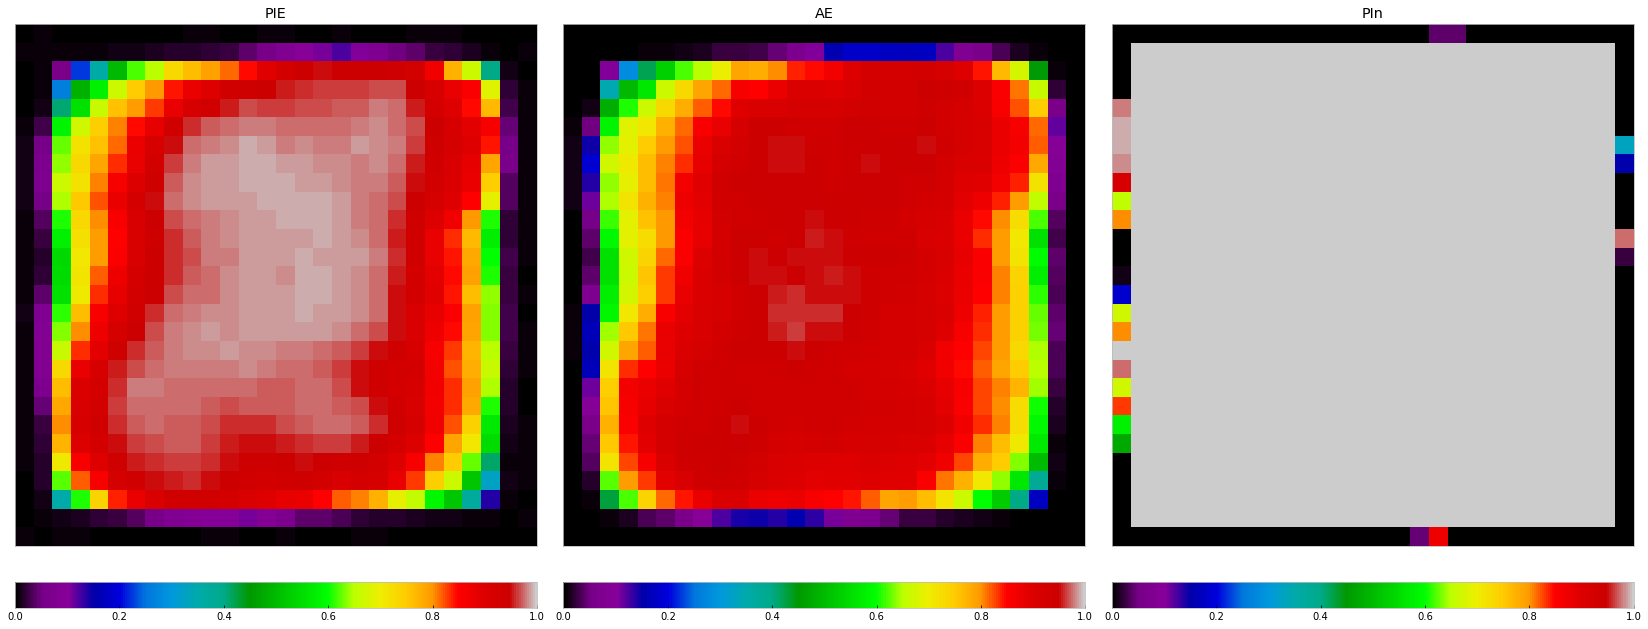

In [23]:
# Plot diagonal / tight frame coefficients
fig, axs = plt.subplots(1, 3, figsize=(23,13))
ims = [None for _ in range(3)]
for i, (k, I) in enumerate(Ids.items()):
    d = torch.diag(I).unflatten(-1, train.size)
    im = axs[i].matshow(d, cmap='nipy_spectral', vmin=0, vmax=1)
    axs[i].grid(False)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(f"{k}")
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04, orientation="horizontal")
    
plt.savefig(f'../figures/other/{experiment_name}_diagarea.pdf')

In [24]:
# Calculate condition numbers
print("Condition Numbers:")
for i, (k, I) in enumerate(Ids.items()):
    kappa = torch.linalg.cond(I)
    print(f'{k:5} {kappa.item():5E}')

Condition Numbers:
PIE   7.106098E+07
AE    3.016824E+08
PIn   2.398625E+08


In [25]:
# Calculate approximate Lipshitz constants / spectral norms
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model.get_weight_dict()
    lipschitz_constants = torch.tensor([
        utils.metrics.stochastic_spectral_norm(w, 15) 
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)
    print(f'{k:5} {lipschitz_product.item():5E}')

Lipschitz Constants:
PIE   2.297515E+00
AE    1.414840E+01


In [26]:
# Calculate actual Lipshitz constants / spectral norms
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model.get_weight_dict()
    lipschitz_constants = torch.tensor([
        torch.svd(w)[1][0]
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)
    print(f'{k:5} {lipschitz_product.item():5E}')

Lipschitz Constants:
PIE   2.589937E+00
AE    1.532637E+01


In [27]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Calculate estimated Jacobian from test data
# NOTE: This process can take upwards of 10 minutes
no_cond = 1000
_x = test_tensor.clone()[:no_cond].to(device)
_x.requires_grad = True
Js = {}
for k, model in nets.items():
    Js[k] = torch.zeros(no_cond, M, M)
    for i in tqdm(range(no_cond)):
        model.zero_grad()
        Js[k][i] = torch.autograd.functional.jacobian(
            lambda x: model.T(model(x)),
            _x[i]
    ).cpu()

# Move models to CPU
for k in nets:
    nets[k] = nets[k].to('cpu')

# Move samples to CPU
_x = _x.to('cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
print("Jacobian Relative Condition Numbers (L2 Norm):")
for k, J in Js.items():
    _xh = nets[k](_x)
    rel = torch.mean(torch.linalg.norm(_xh, dim=1) / torch.linalg.norm(_x, dim=1))
    Jnorm = torch.mean(torch.linalg.norm(J, dim=(1,2)))
    relnorm = torch.mean(
        torch.linalg.norm(J, dim=(1,2)) / (torch.linalg.norm(_xh, dim=1) / torch.linalg.norm(_x, dim=1))
    )
    print(f"{k:3} den: {rel:.6E} abs_cond: {Jnorm:.6E} rel_cond: {relnorm:.6E}") 

Jacobian Relative Condition Numbers (L2 Norm):
PIE den: 9.995363E-01 abs_cond: 2.255097E+01 rel_cond: 2.256186E+01
AE  den: 8.301535E-01 abs_cond: 2.213908E+01 rel_cond: 2.680431E+01


In [29]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [30]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

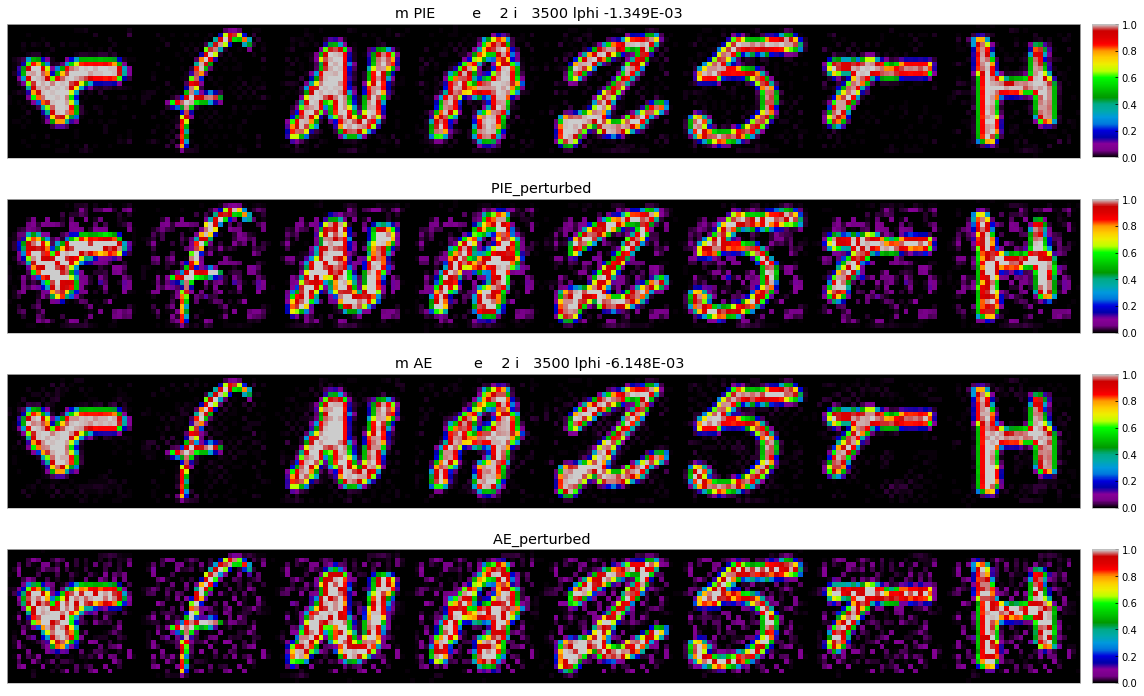

In [31]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)
            
            xh = nets[cur](x)
            xe = nets[cur](x + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs + r))
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

/itf-fi-ml/home/mariuaas/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/itf-fi-ml/home/mariuaas/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


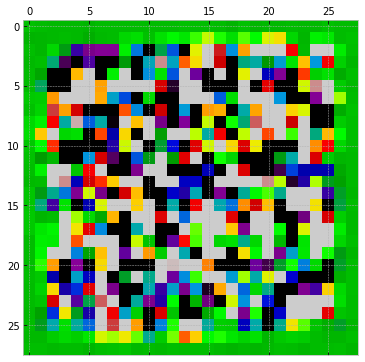

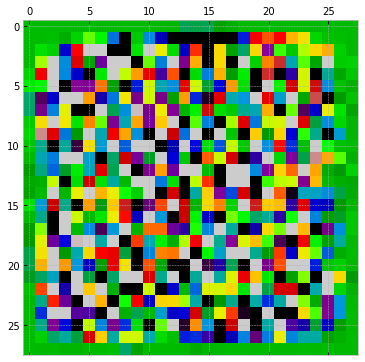

In [32]:
plt.matshow(rs['PIE'].to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)
plt.matshow(rs['AE'].to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)

In [33]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Error:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(test_tensor + r))
    print(f"{k:6}: {utils.metrics.relative_error(test_tensor + rs[k].cpu(), XE, reduction='mean')}")


print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(test_tensor + r))
    XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor, test_tensor + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH, XE, test_tensor, r, reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Error:
PIE   : 0.9192312359809875
AE    : 0.8722078800201416
Relative Cond:
PIE   : 0.104482 0.098739 4.259719
AE    : 0.096520 0.098739 3.935113


In [34]:
_U, _S, _V = torch.svd(
    torch.tensor(train.data / 255.).flatten(-2, -1),
    some=False
)

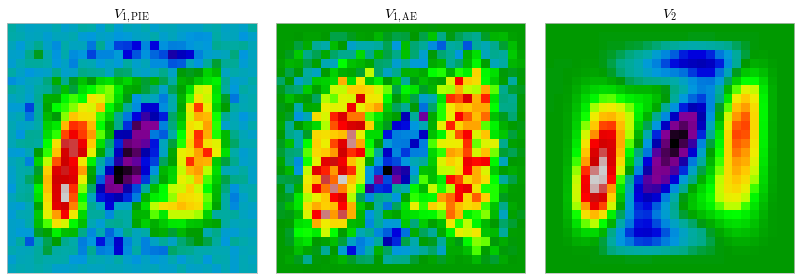

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

axs[0].matshow(-nets['PIE'].net.V.weight.detach()[0].unflatten(-1, train.size))
axs[0].set_title(r'$V_\mathrm{1,{PIE}}$')
axs[1].matshow(-nets['AE'].net_fwd.V.weight.detach()[0].unflatten(-1, train.size))
axs[1].set_title(r'$V_\mathrm{1,{AE}}$')

axs[2].matshow(_V.T.detach()[1].unflatten(-1, train.size))
axs[2].set_title(r'$V_2$')

for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.tight_layout()
plt.savefig(f'../figures/other/{experiment_name}_principal_vectors.pdf')

In [61]:
vpie = -nets['PIE'].net.V.weight.detach()[0].unflatten(-1, train.size)
vae = -nets['AE'].net_fwd.V.weight.detach()[0].unflatten(-1, train.size)
v = _V.T.detach()[1].unflatten(-1, train.size)

print(
    'SSIM\t' +
    f'PIE {utils.metrics.ssim(vpie[None,None,...].double(), v[None,None,...].double()):4E} ' +
    f'AE {utils.metrics.ssim(vae[None,None,...].double(), v[None,None,...].double()):4E} ' +
    '\nRE\t' +
    f'PIE {utils.metrics.relative_error(v, vpie):4E} ' +
    f'AE {utils.metrics.relative_error(v, vae):4E} '
)

SSIM	PIE 6.529917E-01 AE 6.088666E-01 
RE	PIE 2.184552E+02 AE 4.895585E+01 


In [36]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [37]:
# Save weights

export_weights = {}
for k in nets:
    export_weights[k] = nets[k].get_weight_dict()
    for l in export_weights[k]:
        export_weights[k][l] = export_weights[k][l].detach().numpy().tolist()

with open(f'{serialized_path}weights.pickle', 'wb') as outfile:
    pickle.dump(export_weights, outfile)

In [38]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)